# Modelling epidemics evolution SIR model through a factored MDP

brief descrition about this work

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danielbdias/mdp-sir-modelling/blob/master/sir_mdp_example.ipynb)

## Dependencies setup

In [1]:
# Uncomment this line to run this code on Google Colab
#!sh -c "$(curl -fsSL https://raw.githubusercontent.com/danielbdias/mdp-sir-modelling/master/google_colab_setup.sh)"

# enable rich graphs instead of images on notebook
import mpld3
mpld3.enable_notebook()

# code dependencies
from sir_modelling.simulation import plot_sir
from sir_modelling.enumerative_model import create_representation
from sir_modelling.enumerative_model_simulation import simulate_policy_with_mdp_model

from mdp.algorithms.value_iteration import enumerative_finite_horizon_value_iteration

## Creating a model

Model parameters

In [2]:
# approximate values by 2 decimal digits
approximation_threshold = 1e-2

# beta (infection rate)
# assumption
# beta < 1.0 - social distancing
# beta >= 1.0 - no social distancing
betas = [0.5, 1.0, 2.5, 4]

# recovery rate (1 person each 4 days)
gamma = 1.0 / 4.0

horizon = 10 # in weeks
discount_factor = 0.9

steps_per_transition = 7 # each chosen action affects the virus evolution by 7 days (1 week)
initial_state = "s_99_i_01_r_00"

Creating MDP representation

In [3]:
reward_function = lambda susceptibles, infective, recovered: 10 * susceptibles + 5 * recovered - 15 * infective
mdp = create_representation(approximation_threshold, gamma, betas, steps_per_transition, reward_function)

print(f"states: {len(mdp.states)}, {mdp.states[0:5]}")
print(f"actions: {mdp.actions}")

states: 5151, ['s_00_i_00_r_100', 's_00_i_01_r_99', 's_00_i_02_r_98', 's_00_i_03_r_97', 's_00_i_04_r_96']
actions: [0.5, 1.0, 2.5, 4]


Running Value Iteration on model

In [4]:
policy, value_function, statistics = enumerative_finite_horizon_value_iteration(mdp, discount_factor, horizon)

print(f"max value: {max(value_function)}")
print(f"policy for initial state: {policy[initial_state]}")
print(f"[min max] betas in policy: [{min(policy.values())} {max(policy.values())}]")

max value: [6513.215599]
policy for initial state: 0.5
[min max] betas in policy: [0.5 4]


Simulate model using MDP

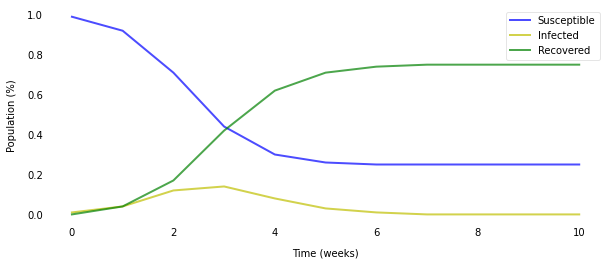

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


In [5]:
chosen_betas, S, I, R = simulate_policy_with_mdp_model(policy, initial_state, mdp, horizon, approximation_threshold)

t = list(range(horizon + 1))
plot_sir(t, S, I, R, time_label="weeks")
print(chosen_betas)